# Soft Action Critic

## Installation

In [63]:
!pip install gymnasium
!pip install -q swig
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


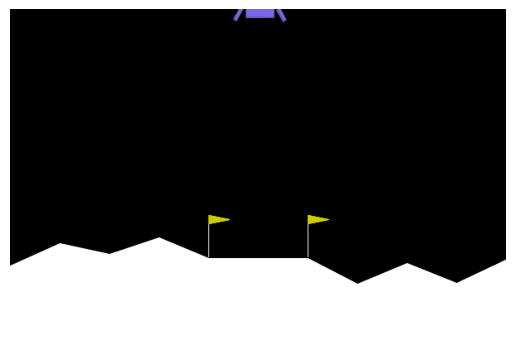

In [64]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
env.reset()

plt.imshow(env.render())
plt.axis("off");

## Definitions

In [65]:
from collections import deque
import random

class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [73]:
from gymnasium.wrappers import RecordVideo

def create_gym_environment(name):
  environment = gym.make(name, render_mode="rgb_array")
  environment = RecordVideo(environment, video_folder=f"./{name}_recored_episodes", episode_trigger=lambda x: x % 10 == 0, disable_logger=True)

  return environment

In [74]:
import torch
from torch.nn import Sequential, Linear, ReLU, Module

class DQN(Module):

  def __init__(self, hidden_size, obs_size, out_dims):
    super().__init__()
    self.net = Sequential(
        Linear(obs_size + out_dims, hidden_size),
        ReLU(),
        Linear(hidden_size, hidden_size),
        ReLU(),
        Linear(hidden_size, 1)
    )

  def forward(self, state, action):
    in_vector = torch.hstack((state, action)).float()
    return self.net(in_vector)



In [75]:
import numpy
from torch.nn import Sequential, Linear, ReLU, Module
from torch.nn.functional import softplus
from torch.distributions.normal import Normal


class GradientPolicy(Module):
  def __init__(self, hidden_size, obs_size, out_dims):
    super().__init__()

    self.net = Sequential(
        Linear(obs_size, hidden_size),
        ReLU(),
        Linear(hidden_size, hidden_size),
        ReLU()
    )

    self.linear_mu = Linear(hidden_size, out_dims)
    self.linear_std = Linear(hidden_size, out_dims)

  def forward(self, obs):
      x = self.net(obs)
      mu = self.linear_mu(x)
      std = self.linear_std(x)
      std = softplus(std) + 1e-3

      dist = Normal(mu, std)
      action = dist.rsample()

      log_prob = dist.log_prob(action)
      log_prob = log_prob.sum(dim=-1, keepdim=True)

      action = torch.tanh(action)

      return action, log_prob

In [76]:
def polyak_average(net, target_net, tau=0.01):
  for qp, tp in zip(net.parameters(), target_net.parameters()):
    tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

In [77]:
from copy import deepcopy
from torch.nn.functional import smooth_l1_loss
from torch.optim import AdamW
import itertools
import time
import numpy as np


class SoftActionCritic():

  def __init__(self, env_name, q_nets = None, schedulers=None, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, alpha=0.02, tau=0.05,
               loss_fn=smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=600, samples_per_epoch=1024, sync_rate=25, repeat_action_rate=5):
      self.env_name = env_name
      self.env = create_gym_environment(env_name)

      obs_size = self.env.observation_space.shape[0]
      n_actions = self.env.action_space.shape[0]
      if q_nets:
        self.q_net1 = q_nets["q_net1"]
        self.q_net2 = q_nets["q_net2"]
        self.policy = q_nets["policy"]
      else:
        self.q_net1 = DQN(hidden_size, obs_size, n_actions)
        self.q_net2 = DQN(hidden_size, obs_size, n_actions)
        self.policy = GradientPolicy(hidden_size, obs_size, n_actions)

      self.target_q_net1 = deepcopy(self.q_net1)
      self.target_q_net2 = deepcopy(self.q_net2)
      self.target_policy = deepcopy(self.policy)

      self.schedulers = schedulers

      self.buffer = ReplayBuffer(capacity=capacity)
      self.loss_fn = loss_fn

      self.gamma = gamma
      self.alpha = alpha
      self.tau = tau
      self.batch_size = batch_size
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.eps_last_episode = eps_last_episode
      self.sync_rate = sync_rate
      self.samples_per_epoch = samples_per_epoch
      self.lr = lr

      q_net_params = itertools.chain(self.q_net1.parameters(), self.q_net2.parameters())
      self.q_net_optimizer = optim(q_net_params, lr=self.lr)
      self.policy_optimizer = optim(self.policy.parameters(), lr=self.lr)

      self.current_epoch = 1
      self.log = []
      self.returns = []
      self.episode_lengths = []
      self.start_time = time.time()
      self.repeat_action_rate = repeat_action_rate

      while len(self.buffer) < self.samples_per_epoch:
        self.play_episode()

  @torch.no_grad()
  def play_episode(self, policy=None):
      state = self.env.reset()[0]
      done = False
      rewards = 0
      epsiode_length = 0

      while not done:
        state_v = torch.tensor(state)
        if policy:
          action, _ = self.policy(state_v)
          action = action.cpu().numpy()
        else:
          action = self.env.action_space.sample()

        for _ in range(self.repeat_action_rate):
          next_state, reward, done1, done2, info = self.env.step(action)
          rewards += reward
          epsiode_length += 1
        done = done1 or done2

        next_state_v = torch.tensor(next_state)
        action_v = torch.tensor(action)
        reward_v = torch.tensor(reward)
        done_v = torch.tensor(done)
        exp = (state_v, action_v, reward_v, done_v, next_state_v)

        self.buffer.append(exp)
        state = next_state
      return rewards, epsiode_length

  def training_step(self):
      batch_T = self.buffer.sample(self.batch_size)
      batch = list(map(torch.stack, zip(*batch_T)))

      states, actions, rewards, dones, next_states = batch
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)

      action_values1 = self.q_net1(states, actions)
      action_values2 = self.q_net2(states, actions)

      target_actions, target_log_probs = self.target_policy(next_states)

      next_action_values = torch.min(
          self.target_q_net1(next_states, target_actions),
          self.target_q_net2(next_states, target_actions)
      )

      next_action_values[dones] = 0.0

      expected_action_values = rewards + self.gamma * (next_action_values - self.alpha*target_log_probs)

      q_loss1 = self.loss_fn(action_values1, expected_action_values)
      q_loss2 = self.loss_fn(action_values2, expected_action_values)

      q_loss_total = q_loss1 + q_loss2

      self.q_net_optimizer.zero_grad()
      q_loss_total.backward()
      self.q_net_optimizer.step()


      actions, log_probs = self.policy(states)

      action_values = torch.min(self.q_net1(states, actions),
                                self.q_net2(states, actions)
                                )

      policy_loss = (self.alpha * log_probs - action_values).mean()

      self.policy_optimizer.zero_grad()
      policy_loss.backward()
      self.policy_optimizer.step()

      return q_loss_total, policy_loss

  def step_schedulers(self):
    if self.schedulers:
      for scheduler in self.schedulers:
        scheduler(self)

  def training_epoch_end(self):
    last_return, episode_length = self.play_episode(self.policy)

    polyak_average(self.q_net1, self.target_q_net1, tau=self.tau)
    polyak_average(self.q_net2, self.target_q_net2, tau=self.tau)
    polyak_average(self.policy, self.target_policy, tau=self.tau)

    self.step_schedulers()
    self.current_epoch += 1
    return last_return, episode_length


  def fit(self, n_epoch):
    for epoch in range(n_epoch):
      loss_total = 0
      for _ in range(self.samples_per_epoch//self.batch_size):
        loss = self.training_step()

      last_return, episode_length  = self.training_epoch_end()

      self.returns.append(last_return)
      self.episode_lengths.append(episode_length)
      self.log.append([self.current_epoch, last_return])

      if self.current_epoch % 25 == 0:
        print(f"Epoch: {self.current_epoch}, mean return: {np.mean(self.returns[-10:]):.2f}, " \
          f"mean episode length: {np.mean(self.episode_lengths[-10:])}")

## Training

In [81]:
def alpha_scheduler(algo):
  epoch = algo.current_epoch
  previous_alpha = algo.alpha
  if epoch > 1000:
    algo.alpha = 0.01
  elif epoch > 600:
   algo.alpha = 0.02
  elif epoch > 400:
   algo.alpha = 0.03
  elif epoch > 200:
    algo.alpha = 0.04
  if previous_alpha != algo.alpha:
    print(f"Current \"alpha\" is {algo.alpha}")

In [82]:
import shutil

try:
    shutil.rmtree("/content/LunarLanderContinuous-v2_recored_episodes", ignore_errors=True)
except:
    pass

In [83]:
alg = SoftActionCritic('LunarLanderContinuous-v2', q_nets=None, schedulers=[alpha_scheduler], repeat_action_rate=2)
alg.fit(2000)

Epoch: 25, mean return: -311.62, mean episode length: 113.2
Epoch: 50, mean return: -127.07, mean episode length: 675.8
Epoch: 75, mean return: -273.08, mean episode length: 696.0


Epoch: 100, mean return: -119.60, mean episode length: 901.2
Epoch: 125, mean return: -106.94, mean episode length: 906.0
Epoch: 150, mean return: -51.89, mean episode length: 977.8
Epoch: 175, mean return: -77.57, mean episode length: 992.2
Epoch: 200, mean return: -80.85, mean episode length: 1000.0
Current "alpha" is 0.04
Epoch: 225, mean return: -82.83, mean episode length: 972.8
Epoch: 250, mean return: -40.62, mean episode length: 953.4
Epoch: 275, mean return: -47.54, mean episode length: 947.8
Epoch: 300, mean return: -48.78, mean episode length: 947.4
Epoch: 325, mean return: 16.33, mean episode length: 944.2
Epoch: 350, mean return: 13.33, mean episode length: 938.8
Epoch: 375, mean return: -18.95, mean episode length: 638.0
Epoch: 400, mean return: -91.35, mean episode length: 632.4
Current "alpha" is 0.03
Epoch: 425, mean return: -71.09, mean episode length: 624.4
Epoch: 450, mean return: -117.94, mean episode length: 338.0
Epoch: 475, mean return: -93.24, mean episode leng

In [90]:
torch.save(alg.policy, "SAC_LunarLander_policy")
torch.save(alg.q_net1, "SAC_LunarLander_qnet1")
torch.save(alg.q_net2, "SAC_LunarLander_qnet2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Testing

In [91]:
policy = torch.load("SAC_LunarLander_policy")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
from gymnasium.wrappers import RecordVideo

def create_test_gym_environment(name):
  environment = gym.make(name, render_mode="rgb_array")
  environment = RecordVideo(environment, video_folder=f"./test_{name}", episode_trigger=lambda x: x % 1 == 0)

  return environment

In [93]:
@torch.no_grad()
def play_episode(test_env, policy, repeat_action_rate):
    state = test_env.reset()[0]
    done = False

    while not done:
        state_v = torch.tensor(state)
        action, _ = policy(state_v)
        action = action.cpu().numpy()

        for _ in range(repeat_action_rate):
          next_state, reward, done1, done2, info = test_env.step(action)
        done = done1 or done2
        state = next_state

In [94]:
test_env = create_test_gym_environment('LunarLanderContinuous-v2')

for _ in range(10):
  play_episode(test_env, policy, 2)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/test_LunarLanderContinuous-v2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-0.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-0.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-1.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-1.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-2.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-2.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-3.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-3.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-4.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-4.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-5.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-5.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-6.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-6.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-7.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-7.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-8.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-8.mp4
Moviepy - Building video /content/test_LunarLanderContinuous-v2/rl-video-episode-9.mp4.
Moviepy - Writing video /content/test_LunarLanderContinuous-v2/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /content/test_LunarLanderContinuous-v2/rl-video-episode-9.mp4
